### This notebook for training MNIST CNN
- A DNN network
- A Simple CNN network
- A Normal CNN network

In [21]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [22]:
neuros = 500
# neuros = 200

In [23]:
class DNNNet(nn.Module):
    def __init__(self):
        super(DNNNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):

        x = x.view(-1, 28 * 28 * 1)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [24]:
class SimpleCNNNet(nn.Module):
    def __init__(self):
        super(SimpleCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.fc1 = nn.Linear(12 * 12 * 20, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 12 * 12 * 20)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [25]:
class CNNNet(nn.Module):

    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [26]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if False:
                break

In [27]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return round((100. * correct / len(test_loader.dataset)),3)

In [28]:
net_list = ['dnn', 'scnn', 'cnn']
accuracys = []

learning_rate = 0.005
step_size=1
gamma=0.7
epoch_num = 15

for net in net_list:
    print('==============', net,'================')
    # Training settings
    use_cuda = not False and torch.cuda.is_available()
    accuracy_list = []
    torch.manual_seed(1)
    device = torch.device("cuda" if use_cuda else "cpu")
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                      'pin_memory': True,
                      'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                      transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                      transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    if net == 'dnn':
        model = DNNNet().to(device)
    elif net == 'scnn':
        model = SimpleCNNNet().to(device)
    elif net == 'cnn':
        model = CNNNet().to(device)

    optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate)
  # optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    for epoch in range(1, epoch_num + 1):
        train(None, model, device, train_loader, optimizer, epoch)
        a = test(model, device, test_loader)
        accuracy_list.append(a)
        scheduler.step()

    if True:
        if net == 'dnn':
            torch.save(model.state_dict(), "mnist_dnn_net_"+str(neuros)+".pt")
        elif net == 'scnn':
            torch.save(model.state_dict(), "mnist_cnn_net_simple_"+str(neuros)+".pt")
        elif net == 'cnn':
            torch.save(model.state_dict(), "mnist_cnn_net_"+str(neuros)+".pt")
    print(accuracy_list)
    accuracys.append(accuracy_list)

print(accuracys)

============== dnn ================
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348172
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.047725

Test set: Average loss: 0.1636, Accuracy: 9540/10000 (95.400%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.151534
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.129905

Test set: Average loss: 0.1060, Accuracy: 9684/10000 (96.840%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.082542
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.061495

Test set: Average loss: 0.0962, Accuracy: 9746/10000 (97.460%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.037278
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.000490

Test set: Average loss: 0.0830, Accuracy: 9781/10000 (97.810%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.060247
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001677

Test set: Average loss: 0.0835, Accuracy: 9809/10000 (98.090%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001056
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.010031

Test set: Average loss: 0.0827, Accuracy: 9794/10000 (97.940%)

Trai

In [1]:
accuracys = [[95.4, 96.84, 97.46, 97.81, 98.09, 97.94, 98.33, 98.36, 98.36, 98.42, 98.46, 98.38, 98.43, 98.42, 98.4], 
             [97.59, 98.33, 98.88, 98.91, 98.99, 99.02, 99.11, 99.08, 99.11, 99.16, 99.16, 99.16, 99.16, 99.17, 99.16], 
             [97.28, 97.92, 98.79, 98.87, 99.04, 99.1, 99.03, 99.07, 99.04, 99.09, 99.05, 99.07, 99.1, 99.09, 99.07]]


[[95.4, 96.84, 97.46, 97.81, 98.09, 97.94, 98.33, 98.36, 98.36, 98.42, 98.46, 98.38, 98.43, 98.42, 98.4], [97.59, 98.33, 98.88, 98.91, 98.99, 99.02, 99.11, 99.08, 99.11, 99.16, 99.16, 99.16, 99.16, 99.17, 99.16], [97.28, 97.92, 98.79, 98.87, 99.04, 99.1, 99.03, 99.07, 99.04, 99.09, 99.05, 99.07, 99.1, 99.09, 99.07]]


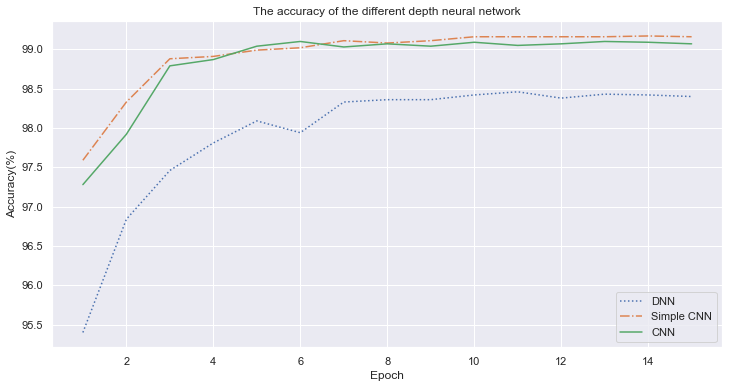

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="darkgrid")
epoch_num = 15
print(accuracys)
x = range(1, epoch_num+1)
plt.figure(figsize=(12, 6))
y1 = accuracys[0]
y2 = accuracys[1]
y3 = accuracys[2]
plt.plot(x, y1, label='DNN', linestyle='dotted')
plt.plot(x, y2, label='Simple CNN', linestyle='dashdot')
plt.plot(x, y3, label='CNN')
plt.yticks()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.title('The accuracy of the different depth neural network')
plt.show()

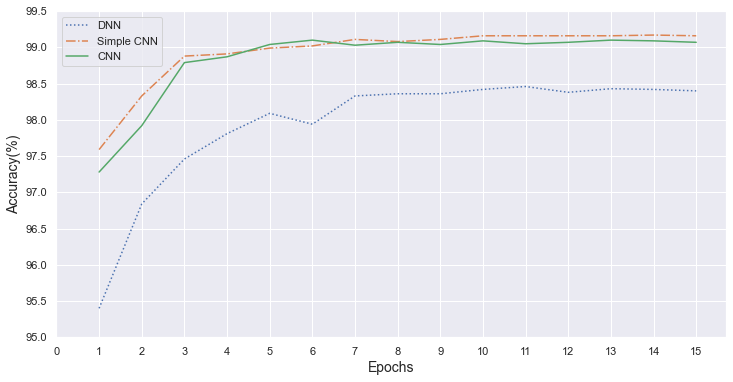

In [7]:
x = range(1, epoch_num+1)
plt.figure(figsize=(12,6))
y1 = accuracys[0]
y2 = accuracys[1]
y3 = accuracys[2]
plt.plot(x, y1, label='DNN', linestyle='dotted')
plt.plot(x, y2, label='Simple CNN', linestyle='dashdot')
plt.plot(x, y3, label='CNN')
ax = plt.subplot()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))
plt.yticks(np.arange(95, 100, 0.5))
plt.xticks(np.arange(0, 16, 1))
plt.legend()
plt.xlabel('Epochs', fontsize='14')
plt.ylabel('Accuracy(%)', fontsize='14')
# plt.title('The accuracy of the different depth neural network')
plt.show()